# Random Forests: Presidential Contributions

Let's look at a random forests models for the presidential dataset.

This dataset defines all presidential contribution amounts from publicly available information.

The purpose here is to try to classify the candidate to whom the contributor contributes.  

Here are the feature columns we will use:
1. Last Name (converted from Contributor Name)
2. First Name (converted from Contributor Name)
3. State 
4. Latitude (converted from Zipcode)
5. Longitude (converted from zipcode)
6. Employer
7. Occupation

### Notes

This is going to be a very difficult dataset to get high accuracy, because we don't have any features that are highly correlated with the outcome. Part of our analysis is to see which features prove to be the most useful. 

One might suspect that information like State, might be very predictive -- because presumably New Yorkers might contribute to Hillary Clinton and Texans might contribute to Donald Trump. However, it turns out that State is pretty weakly correlated to the outcome.  

One nice thing about random forests is that since we "bag" featues in differnet trees, we can empirically see which variables have hte most predictive power.  This is helpful for analytical reasons.



In [0]:
%matplotlib inline
import time
import pandas as pd

## Step 1: Load the data

In [2]:
t1 = time.perf_counter()
dataset = pd.read_csv("https://s3.amazonaws.com/elephantscale-public/data/presidential_election_contribs/2016/2016-medium-clean.csv",)
t2 = time.perf_counter()

print("read {:,} records in {:,.2f} ms".format(len(dataset), (t2-t1)*1000))

dataset.head()

read 9,221 records in 222.68 ms


CONTB_RECEIPT_AMT                    CAND_NM  LASTNAME     FIRSTNAME  \
0                5.0    Clinton, Hillary Rodham    RIGNEY       FARRELL   
1              100.0           Sanders, Bernard    ARNOLD           IRA   
2               24.0  Cruz, Rafael Edward 'Ted'  VANDOREN  HELEN E. MS.   
3              100.0    Clinton, Hillary Rodham  RICHARDS          MARC   
4               10.0    Clinton, Hillary Rodham     MOYER        DENNIS   

  CONTBR_ST        LAT         LNG CONTBR_EMPLOYER       CONTBR_OCCUPATION  
0        CA  33.147294 -117.322181   SELF-EMPLOYED              CONTRACTOR  
1        CA  38.346420 -122.694127            NONE            NOT EMPLOYED  
2        MD  39.002745  -76.931721         RETIRED                 RETIRED  
3        CA  34.070410 -118.350411   SELF-EMPLOYED                     ART  
4        CA  37.916555 -122.341233     MARIN HONDA  WARRANTY ADMINISTRATOR

In [0]:
prediction_column = ['CAND_NM']
numeric_columns = ['LAT', 'LNG']
feature_columns = ['LASTNAME', 'FIRSTNAME', 'CONTBR_ST', 'LAT', 'LNG', 'CONTBR_EMPLOYER', "CONTBR_OCCUPATION"]
categorical_columns = ['LASTNAME', 'FIRSTNAME', 'CONTBR_ST', 'CONTBR_EMPLOYER', "CONTBR_OCCUPATION"]
categorical_index = ['FIRSTNAME_index', 'LASTNAME_index', 'CONTBR_ST_index', 'CONTBR_EMPLOYER_index', 
                     "CONTBR_OCCUPATION_index"]

### Print out a contribution count broken down by candidate?
**=> Q : Which candidates got the most donations? (in terms of number of donors) **

In [4]:
## TODO : print out per candidate breakdown
## Hint : What column represents Candidate name
s = dataset.groupby('CAND_NM')['CAND_NM'].count()
s


CAND_NM
Bush, Jeb                      41
Carson, Benjamin S.           343
Christie, Christopher J.        7
Clinton, Hillary Rodham      4355
Cruz, Rafael Edward 'Ted'     722
Fiorina, Carly                 35
Graham, Lindsey O.              5
Huckabee, Mike                  8
Johnson, Gary                  11
Kasich, John R.                42
Lessig, Lawrence                3
McMullin, Evan                  6
O'Malley, Martin Joseph         9
Pataki, George E.               1
Paul, Rand                     42
Perry, James R. (Rick)          2
Rubio, Marco                  128
Sanders, Bernard             2506
Santorum, Richard J.            3
Stein, Jill                    11
Trump, Donald J.              935
Walker, Scott                   5
Webb, James Henry Jr.           1
Name: CAND_NM, dtype: int64

In [5]:
print("*=> Q : Which candidates got the most donations? (in terms of number of donors) *\n Ans : ")

s.idxmax()

*=> Q : Which candidates got the most donations? (in terms of number of donors) *
 Ans : 


'Clinton, Hillary Rodham'

In [6]:
## TODO : sort the output by number of contributions
s.sort_values(ascending=False)

CAND_NM
Clinton, Hillary Rodham      4355
Sanders, Bernard             2506
Trump, Donald J.              935
Cruz, Rafael Edward 'Ted'     722
Carson, Benjamin S.           343
Rubio, Marco                  128
Paul, Rand                     42
Kasich, John R.                42
Bush, Jeb                      41
Fiorina, Carly                 35
Stein, Jill                    11
Johnson, Gary                  11
O'Malley, Martin Joseph         9
Huckabee, Mike                  8
Christie, Christopher J.        7
McMullin, Evan                  6
Graham, Lindsey O.              5
Walker, Scott                   5
Lessig, Lawrence                3
Santorum, Richard J.            3
Perry, James R. (Rick)          2
Pataki, George E.               1
Webb, James Henry Jr.           1
Name: CAND_NM, dtype: int64

## Step 2: Build Indexers and feature vector

Let's index all the categorical columns, and build a labeld index.

In [7]:
for col in categorical_columns:
    dataset[col + '_index'] = pd.factorize(dataset[col])[0]
    
dataset.head()

CONTB_RECEIPT_AMT                    CAND_NM  LASTNAME     FIRSTNAME  \
0                5.0    Clinton, Hillary Rodham    RIGNEY       FARRELL   
1              100.0           Sanders, Bernard    ARNOLD           IRA   
2               24.0  Cruz, Rafael Edward 'Ted'  VANDOREN  HELEN E. MS.   
3              100.0    Clinton, Hillary Rodham  RICHARDS          MARC   
4               10.0    Clinton, Hillary Rodham     MOYER        DENNIS   

  CONTBR_ST        LAT         LNG CONTBR_EMPLOYER       CONTBR_OCCUPATION  \
0        CA  33.147294 -117.322181   SELF-EMPLOYED              CONTRACTOR   
1        CA  38.346420 -122.694127            NONE            NOT EMPLOYED   
2        MD  39.002745  -76.931721         RETIRED                 RETIRED   
3        CA  34.070410 -118.350411   SELF-EMPLOYED                     ART   
4        CA  37.916555 -122.341233     MARIN HONDA  WARRANTY ADMINISTRATOR   

   LASTNAME_index  FIRSTNAME_index  CONTBR_ST_index  CONTBR_EMPLOYER_index  \
0               0                0                0                      0   
1               1                1                0                      1   
2               2                2                1                      2   
3               3                3                0                      0   
4               4                4                0                      3   

   CONTBR_OCCUPATION_index  
0                        0  
1                        1  
2                        2  
3                        3  
4                        4

In [8]:
features = dataset[numeric_columns + categorical_index] # numeric columns plus our *_index columns
label =  dataset[prediction_column]#  What are we trying to predict?

label.size

9221

## Step 4: Split data into training and test

**=> TODO: build training and test datasets 70%/30% **


In [9]:
## TODO : split 70% training and 30% testing
## Hint : 0.7 ,  0.3

from sklearn.model_selection import train_test_split
train_x, test_x,train_y, test_y = train_test_split(features, 
                                                    label, test_size=0.3)
print("training set = " , len(train_x))
print("testing set = " , len(test_x))

training set =  6454
testing set =  2767


## Step 5: Train the Model


In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20)

In [12]:
print("Starting model training....this will take some time")
t1 = time.perf_counter()
## TODO : train the model with our training set
## Hint : training
rf.fit(train_x,train_y)
t2 = time.perf_counter()
print("trained on {:,} records  in {:,.2f} ms".\
      format(len(train_x),  (t2-t1)*1000))

Starting model training....this will take some time


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


trained on 6,454 records  in 353.63 ms


In [13]:
## TODO : predict with our test data
## Hint : testData2

t1 = time.perf_counter()
predictions = rf.predict(test_x)
t2 = time.perf_counter()
print("prediction on {:,} records  in {:,.2f} ms".\
      format(len(test_x),  (t2-t1)*1000))

predictions

prediction on 2,767 records  in 27.31 ms


array(['Sanders, Bernard', 'Trump, Donald J.', 'Clinton, Hillary Rodham',
       ..., 'Clinton, Hillary Rodham', 'Clinton, Hillary Rodham',
       'Sanders, Bernard'], dtype=object)

## Step 6: Evaulate the model

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

0.6187206360679436

**=> TODO: Think about the test error here?  Does it seem high?  What does that say about our model?**

**=> How do we define model success? **

In [0]:
import numpy as np
names = np.unique(predictions)

In [16]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(test_y, predictions, labels=names), index=names, columns=names)

Bush, Jeb  Carson, Benjamin S.  \
Bush, Jeb                          1                    0   
Carson, Benjamin S.                0                   14   
Clinton, Hillary Rodham            0                    2   
Cruz, Rafael Edward 'Ted'          0                   22   
Fiorina, Carly                     0                    2   
Rubio, Marco                       0                    2   
Sanders, Bernard                   1                    1   
Stein, Jill                        0                    0   
Trump, Donald J.                   1                   12   

                           Clinton, Hillary Rodham  Cruz, Rafael Edward 'Ted'  \
Bush, Jeb                                        7                          0   
Carson, Benjamin S.                             23                         25   
Clinton, Hillary Rodham                       1127                         10   
Cruz, Rafael Edward 'Ted'                       74                         38   
Fiorina, Carly                                   7                          1   
Rubio, Marco                                    24                          9   
Sanders, Bernard                               275                         13   
Stein, Jill                                      1                          1   
Trump, Donald J.                                91                         36   

                           Fiorina, Carly  Rubio, Marco  Sanders, Bernard  \
Bush, Jeb                               0             0                 3   
Carson, Benjamin S.                     0             2                20   
Clinton, Hillary Rodham                 0             0               156   
Cruz, Rafael Edward 'Ted'               1             0                41   
Fiorina, Carly                          0             0                 2   
Rubio, Marco                            0             1                 6   
Sanders, Bernard                        0             0               411   
Stein, Jill                             0             0                 1   
Trump, Donald J.                        0             5                23   

                           Stein, Jill  Trump, Donald J.  
Bush, Jeb                            0                 1  
Carson, Benjamin S.                  0                26  
Clinton, Hillary Rodham              0                21  
Cruz, Rafael Edward 'Ted'            0                32  
Fiorina, Carly                       0                 5  
Rubio, Marco                         0                 9  
Sanders, Bernard                     1                11  
Stein, Jill                          0                 0  
Trump, Donald J.                     0               120

Use the list above to interpret the label.  

**=>What can you conclude from the confusion matrix?**

Is our model better at predicting candidates with many donations (Clinton, Sanders), or few donations?

What can you say about our model perfromance.

## Step 8: Print the feature importanes

In [17]:
import pandas as pd
rf.feature_importances_

array([0.12859617, 0.13242943, 0.12352051, 0.11751588, 0.05159037,
       0.24196724, 0.20438041])

In [18]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                 index = train_x.columns,
                                 columns=['importance']).sort_values('importance', ascending=False)
feature_importances

importance
CONTBR_EMPLOYER_index      0.241967
CONTBR_OCCUPATION_index    0.204380
LNG                        0.132429
LAT                        0.128596
FIRSTNAME_index            0.123521
LASTNAME_index             0.117516
CONTBR_ST_index            0.051590

**=> TODO Compare the relative weight of the feature importances? **



### Visualize feature importances

TODO: DO a visualization of feature importances.

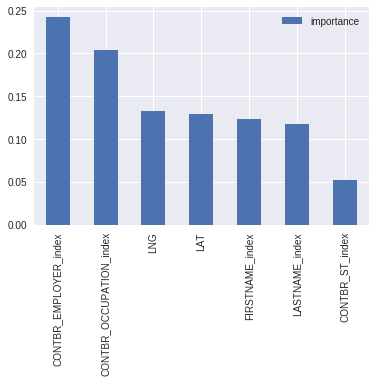

In [19]:
feature_importances.plot.bar()

**=> TODO Compare the relative weight of the feature importances? **

Why do you think that the lat/long and other fields did not contribute?

**=> BONUS: Do a Pearson Correlation Matrix of the variables to the outcome, to see correlation **

